# Getting image insights with Google's Vision API

In [ ]:
# RUN THIS CELL FIRST

# This runs a script that installs libraries we'll use in this notebook
!bash image-insights-google.sh

In [ ]:
# !pip install Pillow

In [ ]:
# !pip install requests

In [62]:
import os
import json
import requests
import base64
from PIL import Image
from IPython.display import Image as Show
from dotenv import load_dotenv
load_dotenv();

In [63]:
url = 'http://media.johnkeefe.net/class-modules/boat2.jpg'

response = requests.get(url) 
my_image = response.content


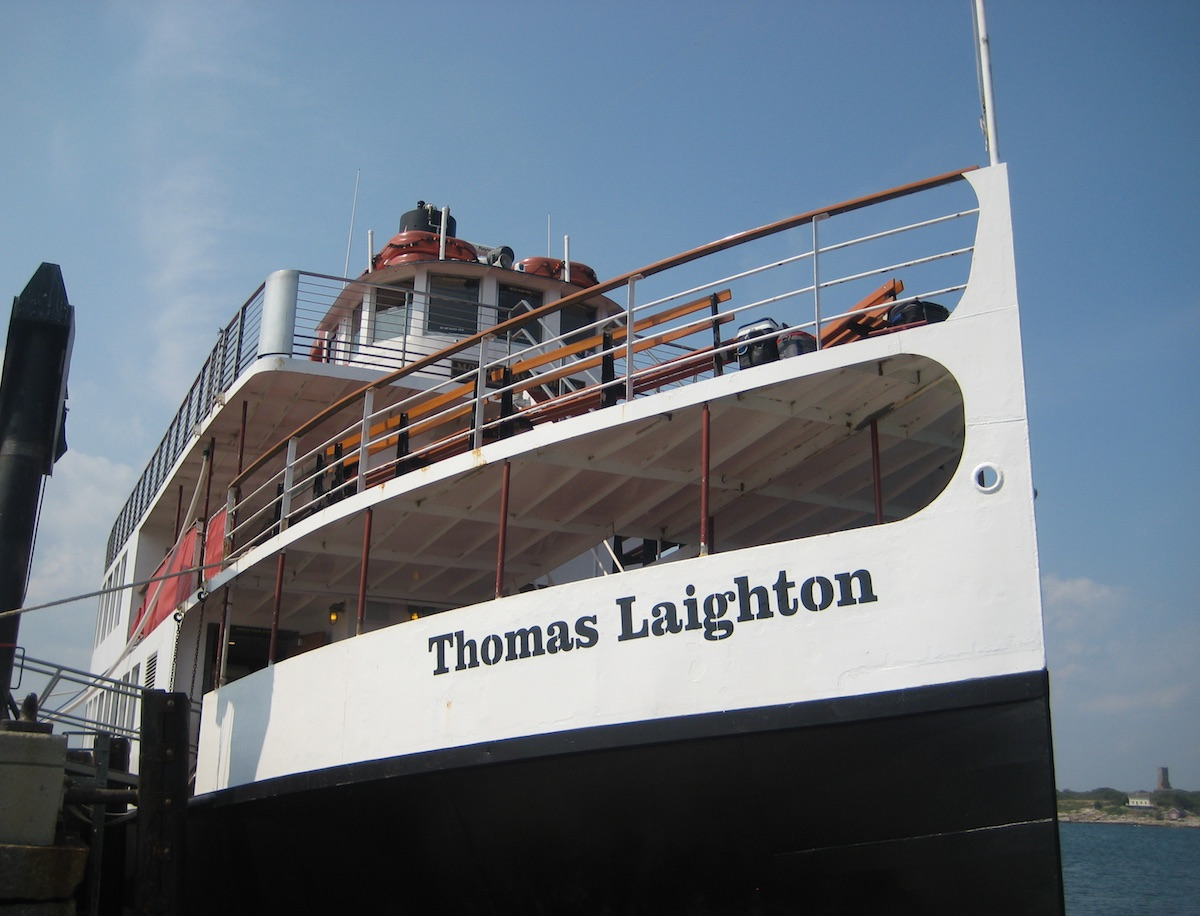

In [25]:
Show(my_image)

In [64]:
my_image_data = str(base64.b64encode(response.content).decode("utf-8"))
my_image_data

'/9j/4AAQSkZJRgABAQAAtAC0AAD/4QKaRXhpZgAATU0AKgAAAAgACAEPAAIAAAAGAAAAbgEQAAIAAAAXAAAAdAESAAMAAAABAAEAAAEaAAUAAAABAAAAjAEbAAUAAAABAAAAlAEoAAMAAAABAAIAAAEyAAIAAAAUAAAAnIdpAAQAAAABAAAAsAAAAABDYW5vbgBDYW5vbiBQb3dlclNob3QgU0QxMDAwAAAAAAC0AAAAAQAAALQAAAABMjAxNzowODoyMiAxNDo0OToxMQAAHYKaAAUAAAABAAACEoKdAAUAAAABAAACGognAAMAAAABAFAAAJAAAAcAAAAEMDIyMJADAAIAAAAUAAACIpAEAAIAAAAUAAACNpEBAAcAAAAEAQIDAJECAAUAAAABAAACSpIBAAoAAAABAAACUpICAAUAAAABAAACWpIEAAoAAAABAAACYpIFAAUAAAABAAACapIHAAMAAAABAAUAAJIJAAMAAAABABgAAJIKAAUAAAABAAACcqAAAAcAAAAEMDEwMKABAAMAAAABAAEAAKACAAQAAAABAAAEsKADAAQAAAABAAADlKIOAAUAAAABAAACeqIPAAUAAAABAAACgqIQAAMAAAABAAIAAKIXAAMAAAABAAIAAKMAAAcAAAABAwAAAKQBAAMAAAABAAAAAKQCAAMAAAABAAAAAKQDAAMAAAABAAAAAKQEAAUAAAABAAACiqQGAAMAAAABAAAAAAAAAAAAAAABAAABQAAAAAgAAAABMjAxNzowODoyMiAxNDo0OToxMQAyMDE3OjA4OjIyIDE0OjQ5OjExAAAAAAUAAAABAAAAhQAAABAAAAAGAAAAAQAAAAAAAAABAAAAXwAAACAAAAAdAAAABQAAoAAAAAADAASTmQAAABYAAAABAAAAAf/hCpxodHRwOi8vbnMuYWRvYmUuY29tL3hhcC8xLjAvADw/eHBhY2tldCBiZWdpbj0i77u/IiBpZD0iVzV

There are details about [how to make a request to the Google Cloud Vision api](https://cloud.google.com/vision/docs/request) if you'd like to read more, but we'll walk through a simple case now.

In [65]:
google_vision_payload = {
    'requests':[
        {
            'image':{
                'content': my_image_data
            },
            'features':[
                {
                    'type':'LABEL_DETECTION'
                },
            ]
        }
    ]
}

In [66]:
google_vision_url = 'https://vision.googleapis.com/v1/images:annotate?key=' + os.getenv("GOOGLE_VISION_API_KEY")

web_request = requests.post(google_vision_url, json=google_vision_payload)

In [67]:
web_request.status_code

200

In [68]:
google_guess = web_request.json()

In [123]:
google_guess['responses']

[{'labelAnnotations': [{'description': 'Water transportation',
    'mid': '/m/08rrcl',
    'score': 0.948979,
    'topicality': 0.948979},
   {'description': 'Ferry',
    'mid': '/m/0ddnl',
    'score': 0.92892295,
    'topicality': 0.92892295},
   {'description': 'Vehicle',
    'mid': '/m/07yv9',
    'score': 0.92071724,
    'topicality': 0.92071724},
   {'description': 'Boat',
    'mid': '/m/019jd',
    'score': 0.87732726,
    'topicality': 0.87732726},
   {'description': 'Ship',
    'mid': '/m/06q74',
    'score': 0.8728268,
    'topicality': 0.8728268},
   {'description': 'Motor ship',
    'mid': '/m/093q8j',
    'score': 0.86523795,
    'topicality': 0.86523795},
   {'description': 'Transport',
    'mid': '/m/07bsy',
    'score': 0.83513474,
    'topicality': 0.83513474},
   {'description': 'Watercraft',
    'mid': '/m/01rzcn',
    'score': 0.8175672,
    'topicality': 0.8175672},
   {'description': 'Mode of transport',
    'mid': '/m/079bkr',
    'score': 0.80817014,
    'topica

In [125]:
google_guess['responses'][0]['labelAnnotations']

[{'description': 'Water transportation',
  'mid': '/m/08rrcl',
  'score': 0.948979,
  'topicality': 0.948979},
 {'description': 'Ferry',
  'mid': '/m/0ddnl',
  'score': 0.92892295,
  'topicality': 0.92892295},
 {'description': 'Vehicle',
  'mid': '/m/07yv9',
  'score': 0.92071724,
  'topicality': 0.92071724},
 {'description': 'Boat',
  'mid': '/m/019jd',
  'score': 0.87732726,
  'topicality': 0.87732726},
 {'description': 'Ship',
  'mid': '/m/06q74',
  'score': 0.8728268,
  'topicality': 0.8728268},
 {'description': 'Motor ship',
  'mid': '/m/093q8j',
  'score': 0.86523795,
  'topicality': 0.86523795},
 {'description': 'Transport',
  'mid': '/m/07bsy',
  'score': 0.83513474,
  'topicality': 0.83513474},
 {'description': 'Watercraft',
  'mid': '/m/01rzcn',
  'score': 0.8175672,
  'topicality': 0.8175672},
 {'description': 'Mode of transport',
  'mid': '/m/079bkr',
  'score': 0.80817014,
  'topicality': 0.80817014},
 {'description': 'Ocean liner',
  'mid': '/m/01vbb5',
  'score': 0.79569

In [101]:
google_guess['responses'][0]['labelAnnotations'][0]

{'description': 'Water transportation',
 'mid': '/m/08rrcl',
 'score': 0.948979,
 'topicality': 0.948979}

In [102]:
google_guess['responses'][0]['labelAnnotations'][0]['description']

'Water transportation'

In [114]:
google_guess['responses'][0]['labelAnnotations'][1]['description']

'Ferry'

In [107]:
for item in google_guess['responses'][0]['labelAnnotations']:
    print(item['description'])

Water transportation
Ferry
Vehicle
Boat
Ship
Motor ship
Transport
Watercraft
Mode of transport
Ocean liner


In [126]:
google_vision_payload = {
    'requests':[
        {
            'image':{
                'content': my_image_data
            },
            'features':[
                {
                    'type':'TEXT_DETECTION'
                }
            ]
        }
    ]
}

In [128]:
google_vision_url = 'https://vision.googleapis.com/v1/images:annotate?key=' + os.getenv("GOOGLE_VISION_API_KEY")

web_request = requests.post(google_vision_url, json=google_vision_payload)

In [129]:
web_request.status_code

200

In [130]:
google_guess = web_request.json()

In [131]:
google_guess['responses'][0]

{'fullTextAnnotation': {'pages': [{'blocks': [{'blockType': 'TEXT',
      'boundingBox': {'vertices': [{'x': 425, 'y': 626},
        {'x': 869, 'y': 555},
        {'x': 879, 'y': 614},
        {'x': 434, 'y': 684}]},
      'paragraphs': [{'boundingBox': {'vertices': [{'x': 425, 'y': 626},
          {'x': 869, 'y': 555},
          {'x': 879, 'y': 614},
          {'x': 434, 'y': 684}]},
        'property': {'detectedLanguages': [{'confidence': 1,
           'languageCode': 'en'}]},
        'words': [{'boundingBox': {'vertices': [{'x': 427, 'y': 636},
            {'x': 595, 'y': 609},
            {'x': 601, 'y': 648},
            {'x': 433, 'y': 675}]},
          'property': {'detectedLanguages': [{'languageCode': 'en'}]},
          'symbols': [{'boundingBox': {'vertices': [{'x': 427, 'y': 636},
              {'x': 447, 'y': 633},
              {'x': 453, 'y': 671},
              {'x': 433, 'y': 675}]},
            'property': {'detectedLanguages': [{'languageCode': 'en'}]},
            '

In [132]:
google_guess['responses'][0]['textAnnotations']

[{'boundingPoly': {'vertices': [{'x': 427, 'y': 556},
    {'x': 879, 'y': 556},
    {'x': 879, 'y': 675},
    {'x': 427, 'y': 675}]},
  'description': 'Thomas Laighton\n',
  'locale': 'en'},
 {'boundingPoly': {'vertices': [{'x': 427, 'y': 636},
    {'x': 595, 'y': 609},
    {'x': 601, 'y': 648},
    {'x': 433, 'y': 675}]},
  'description': 'Thomas'},
 {'boundingPoly': {'vertices': [{'x': 611, 'y': 597},
    {'x': 870, 'y': 556},
    {'x': 879, 'y': 614},
    {'x': 620, 'y': 655}]},
  'description': 'Laighton'}]

In [133]:
google_guess['responses'][0]['fullTextAnnotation']['text']

'Thomas Laighton\n'

In [13]:
google_vision_payload = {
    'requests':[
        {
            'image':{
                'content': my_image_data
            },
            'features':[
                {
                    'type':'WEB_DETECTION',
                    'maxResults':1
                },
            ]
        }
    ]
}

google_vision_url = 'https://vision.googleapis.com/v1/images:annotate?key=' + os.getenv("GOOGLE_VISION_API_KEY")

web_request = requests.post(google_vision_url, json=google_vision_payload)

web_request.status_code

google_guess = web_request.json()



KeyError: 'webEntities'

In [17]:
google_guess['responses'][0]

{'webDetection': {'bestGuessLabels': [{'label': 'hermes house band the rhythm',
    'languageCode': 'en'}],
  'webEntities': [{'description': 'Ferry',
    'entityId': '/m/0ddnl',
    'score': 1.5038874}]}}

In [21]:
google_guess['responses'][0]['webDetection']['webEntities'][0]['description']

'Ferry'

## Processing a set of images

Let's get some images! (Pretend there are 700 instead of 7.)

In [59]:
!wget -N https://s3.amazonaws.com/media.johnkeefe.net/class-modules/images_to_label.zip
!unzip -o -q images_to_label.zip;

--2019-08-03 14:30:27--  https://s3.amazonaws.com/media.johnkeefe.net/class-modules/images_to_label.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.72.18
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.72.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1626400 (1.6M) [application/zip]
Saving to: ‘images_to_label.zip’

images_to_label.zip 100%[===================>]   1.55M  8.08MB/s    in 0.2s    

2019-08-03 14:30:27 (8.08 MB/s) - ‘images_to_label.zip’ saved [1626400/1626400]



In [60]:
os.listdir('images_to_label')

['IMG_8098.JPG',
 'IMG_1454.JPG',
 'IMG_8039.jpg',
 'IMG_8027.JPG',
 'IMG_1407.JPG',
 'IMG_8592.JPG',
 'IMG_8040.JPG']

In [46]:
google_vision_url = 'https://vision.googleapis.com/v1/images:annotate?key=' + os.getenv("GOOGLE_VISION_API_KEY")

# Get the list of files
image_files = os.listdir('images_to_label')

# Loop through the list of files, 
for file in image_files:
    
    # open a file and convert it into image data text
    with open('images_to_label/' + file, "rb") as my_image:
        my_image_data = str(base64.b64encode(my_image.read()).decode("utf-8"))
        
    # set up the google vision options, including the image data text
    google_vision_payload = {
        'requests':[
            {
                'image':{
                    'content': my_image_data
                },
                'features':[
                    {
                        'type':'WEB_DETECTION',
                        'maxResults':1
                    },
                ]
            }
        ]
    }
    
    # hit the google vision api
    web_request = requests.post(google_vision_url, json=google_vision_payload)
    google_guess = web_request.json()
    
    # from the goole response, pull out the webEntity description 
    category = google_guess['responses'][0]['webDetection']['webEntities'][0]['description']
    
    # print the file name and the category guess
    print(file + ',' + category)
    

IMG_8098.JPG,Sunrise
IMG_1454.JPG,Otter
IMG_8039.jpg,Watch
IMG_8027.JPG,Mount Scenery
IMG_1407.JPG,Beach
IMG_8592.JPG,Ferry
IMG_8040.JPG,Water


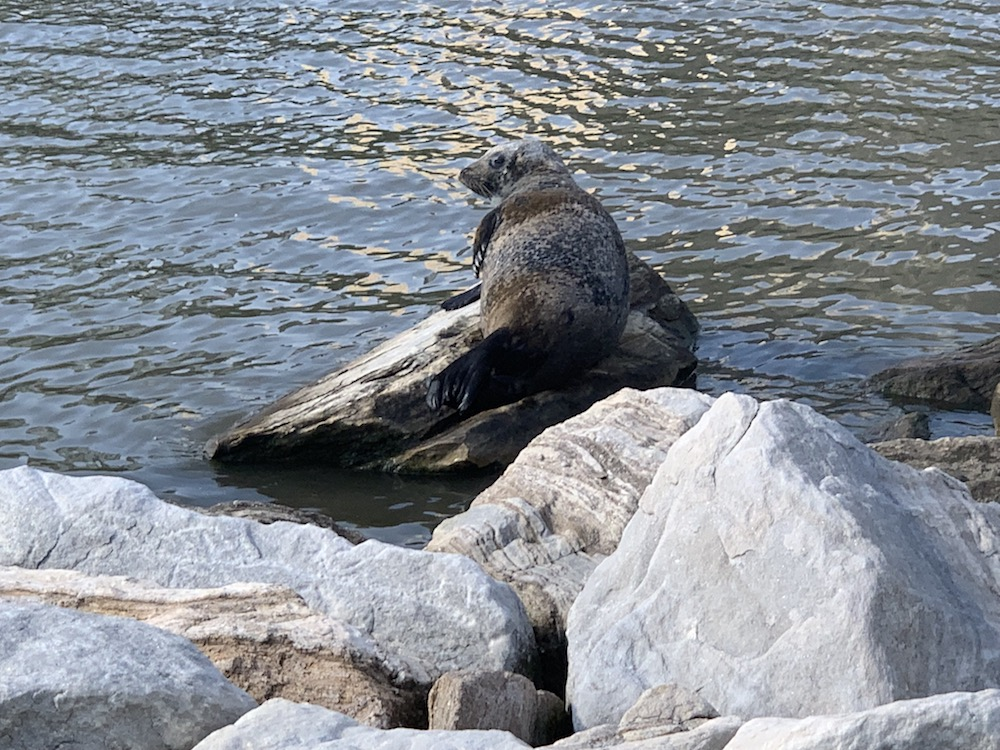

In [48]:
Show(filename='images_to_label/IMG_1454.JPG')

### Extra Challenge

Even more useful would be to save this list as a file! If you're comfortable with Python, you should be able to make that loop pretty easily.

## Google Vision Pricing

You can get topics for 10,000 images for $15.00. [Check out the pricing info](https://cloud.google.com/vision/pricing).